# Анализ Флешмоба с 2023-09-12 по 2023-09-18 

## Общие данные и цели исследования

Был организован флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-09-12 по 2023-09-18.

Задача – оценить эффективность этого мероприятия, а так же имеются ли какие-то долгосрочные эффекты от флешмоба? 

Кроме того, надо учесть, что 2023-09-11 была проведена рекламная кампания, которая разово привлекла большое количество рекламных пользователей.

Смотреть на метрики будем в рамках суточных срезов (то есть ед.измерения 1 сутки)
1. DAU
2. Количество лайков
3. CTR
4. Количество лайков на 1 пост
5. Количество лайков на 1 пользователя
6. Количество активных постов
7. Количество новых постов в каждые сутки (посмотирм на сколько больше постов стало появляться в период флешмоба)

Проверку будем производить с помощью библиотеки CausalImpact.

## Блок общих данных 

In [1]:
# библиотеки для предсказания
import tensorflow as tf
import tensorflow_probability as tfp
from causalimpact import CausalImpact

# для обработки данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os
import datetime
from scipy import stats as st

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

2023-10-30 19:52:52.955883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 19:52:54.286578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Создадим класс для подключения к БД и получения результатов запроса

In [2]:
class getch:
    def __init__(self, query, db=''):
        self.connection = {
            'host': '',
            'password': '',
            'user': '',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = ph.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)

Создадим функцию для предсказания временных рядов на основе библиотеки CausalImpact

In [3]:
def get_causalimpactdata(data_orig='', index_column=None, pre_period=None, post_period=None, model_args={'nseasons': 1, 'season_duration':1}):   
    if len(data_orig) == 0:
        print('Поданы пустые данные')
        return None
    
    else:
        data = data_orig.copy()
        #data['regression'] = data['dt'].where(data['dt'] == '2023-09-11', 0).astype(bool) * 1 - не дало значительного результата
        for i in data.columns:
            if i =='dt' or i == 'period_text':
                pass
            else:
                print('-'*120)
                print(f'Исследуем столбец {i}')
                print('-'*120)
                
                if not index_column:
                    linear_level = tfp.sts.LocalLinearTrend(
                        observed_time_series = st.zscore(data.iloc[:pre_period[1] + 1][i]).astype(np.float32)
                    )                    
                    impact = CausalImpact(data=data[i], #данные
                          pre_period=pre_period, #период до события
                          post_period=post_period, #период после события
                          model_args = model_args,
                          model = linear_level) 
                else:
                    linear_level = tfp.sts.LocalLinearTrend(
                        observed_time_series = st.zscore(data.query(f'dt <= "{pd.to_datetime(pre_period[1])}"')[i]).astype(np.float32)
                    )
                    impact = CausalImpact(data=data.set_index(index_column)[i], #данные
                          pre_period=pre_period, #период до события
                          post_period=post_period, #период после события
                          model_args = model_args,
                          model = linear_level)
                         

                
                impact.plot(figsize=(20, 8))
                print(impact.summary(digits=4))  
                #print(impact.summary('report')) 

## Загрузка данных и подготовка их к исследованию

In [4]:
head_of_db = getch('SELECT * FROM {db}.feed_actions limit 1')

In [5]:
head_of_db.df

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,148500,3137,view,2023-09-13 20:43:41,0,23,Russia,Saint Petersburg,Android,organic,0


Так как данных не очень много, то рассматриваемый период будет от начала создания приложения (начало августа 2023 года)

In [6]:
day_metrics = getch('''
    select toDate(time) as dt,
    count(distinct user_id) as dau,
    countIf(action='like') / countIf(action='view') as ctr,
    countIf(action='like') as like,  
    count(distinct post_id) as active_posts_cnt,  
    count(distinct user_id) / count(distinct post_id) as users_per_post,  
    countIf(action='like') / count(distinct post_id) as like_per_post,
    countIf(action='like') / count(distinct user_id) as like_per_user,
    countIf(action='view') / count(distinct post_id) as view_per_post,
    countIf(action='view') / count(distinct user_id) as view_per_user,
    multiIf(toDate(time) < '2023-09-12', 'pre_flashmobe', toDate(time) > '2023-09-18', 'after_flashmobe', 'flashmobe') as period_text
    from simulator_20230920.feed_actions
    where toDate(time) between '2023-07-01' and '2023-09-30'
    group by toDate(time)
    order by dt
''')

In [7]:
uniq_posts_per_day = getch('''
    select dt, count(post_id) as uniq_posts_cnt, period_text
    from(
        select toDate(time) as dt,
            post_id,
            row_number() over (partition by post_id order by toDate(time)) as first_time_post_action,
            multiIf(toDate(time) < '2023-09-12', 'pre_flashmobe', toDate(time) > '2023-09-18', 'after_flashmobe', 'flashmobe') as period_text
        from simulator_20230920.feed_actions
        where toDate(time) between '2023-07-01' and '2023-09-30'
        group by toDate(time), post_id
    ) as t1
    where first_time_post_action = 1
    group by dt, period_text
    order by dt
''')

In [8]:
top_five_post = getch('''
    with post_id_flashmobe as (
    select post_id
    from(
        select toDate(time) as dt,
            post_id,
            row_number() over (partition by post_id order by toDate(time)) as first_time_post_action,
            multiIf(toDate(time) < '2023-09-12', 'pre_flashmobe', toDate(time) > '2023-09-18', 'after_flashmobe', 'flashmobe') as period_text
        from simulator_20230920.feed_actions
        where toDate(time) between '2023-07-01' and '2023-09-30'
        group by toDate(time), post_id
    ) as t1
    where first_time_post_action = 1 and period_text = 'flashmobe'
    order by post_id
    )

    select post_id, countIf(action='like') as like_cnt, countIf(action='view') as view_cnt, countIf(action='like') / countIf(action='view') as CTR
    from simulator_20230920.feed_actions
    where toDate(time) between '2023-09-12' and '2023-09-18' and post_id in (select * from post_id_flashmobe)
    group by post_id
    order by like_cnt desc
    limit 5
''')

Выведем информативно топ 5 постов, которые были созданы в период с 12.09.2023-18.09.2023 и набрали наибольшее количество лайков за этот период.

In [9]:
top_five_post.df

,post_id,like_cnt,view_cnt,CTR
0,3129,30641,107628,0.284694
1,3120,25636,93235,0.274961
2,3107,22665,82355,0.275211
3,3155,21604,80212,0.269336
4,3289,20631,71075,0.290271


In [10]:
uniq_posts_per_day.df.head()

,dt,uniq_posts_cnt,period_text
0,2023-08-02,89,pre_flashmobe
1,2023-08-03,97,pre_flashmobe
2,2023-08-04,61,pre_flashmobe
3,2023-08-05,87,pre_flashmobe
4,2023-08-06,70,pre_flashmobe


In [11]:
day_metrics.df.head()

,dt,dau,ctr,like,active_posts_cnt,users_per_post,like_per_post,like_per_user,view_per_post,view_per_user,period_text
0,2023-08-02,878,0.205182,1560,89,9.865169,17.528090,1.776765,85.426966,8.659453,pre_flashmobe
1,2023-08-03,2238,0.204174,12816,178,12.573034,72.000000,5.726542,352.640449,28.047364,pre_flashmobe
2,2023-08-04,3105,0.198605,20958,191,16.256545,109.727749,6.749758,552.492147,33.985829,pre_flashmobe
3,2023-08-05,3721,0.200007,23800,211,17.635071,112.796209,6.396130,563.962085,31.979575,pre_flashmobe
4,2023-08-06,4617,0.197783,34504,214,21.574766,161.233645,7.473251,815.205607,37.785142,pre_flashmobe


In [12]:
day_metrics.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                60 non-null     datetime64[ns]
 1   dau               60 non-null     uint64        
 2   ctr               60 non-null     float64       
 3   like              60 non-null     uint64        
 4   active_posts_cnt  60 non-null     uint64        
 5   users_per_post    60 non-null     float64       
 6   like_per_post     60 non-null     float64       
 7   like_per_user     60 non-null     float64       
 8   view_per_post     60 non-null     float64       
 9   view_per_user     60 non-null     float64       
 10  period_text       60 non-null     object        
dtypes: datetime64[ns](1), float64(6), object(1), uint64(3)
memory usage: 5.3+ KB


### Выведем график количества уникальных постов в сутки по дате первого взаимодействия с ними

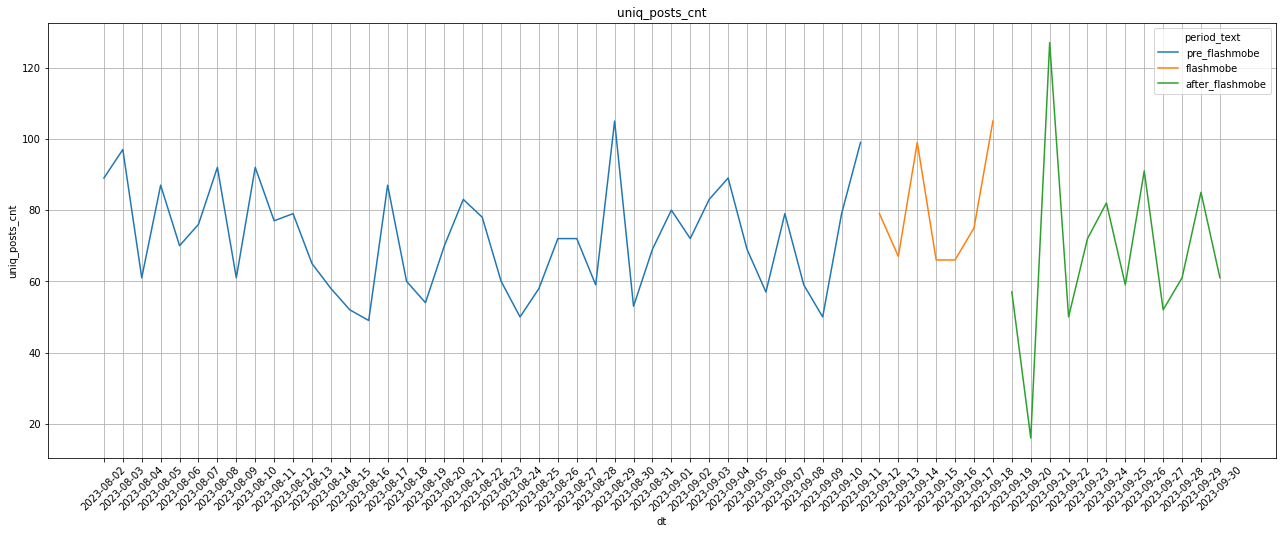

In [13]:
for i in uniq_posts_per_day.df.columns:
    if i =='dt' or i == 'period_text':
        pass
    else:
        plt.figure(figsize=(22,8))
        plt.grid()
        plt.title(i)
        sns.lineplot(data=uniq_posts_per_day.df, x='dt', y=i, hue='period_text')
        plt.xticks (ticks=sorted(uniq_posts_per_day.df['dt'].unique()), rotation=45)
        plt.show()

Визуально тяжело сказать, возросло ли число появления новых постов в период флешмоба

## Выведем информацию по дневным метрикам:
1. Количество уникальных пользователей (DAU)
2. CTR
3. Количество лайков
4. Количество активных уникальных постов
5. Соотношение пользоватлей к постам
6. Количество лайков на 1 пост
7. Количество лайков на 1 пользователя
8. Количество просмотров на 1 пост
9. Количество просмотров на 1 пользователя

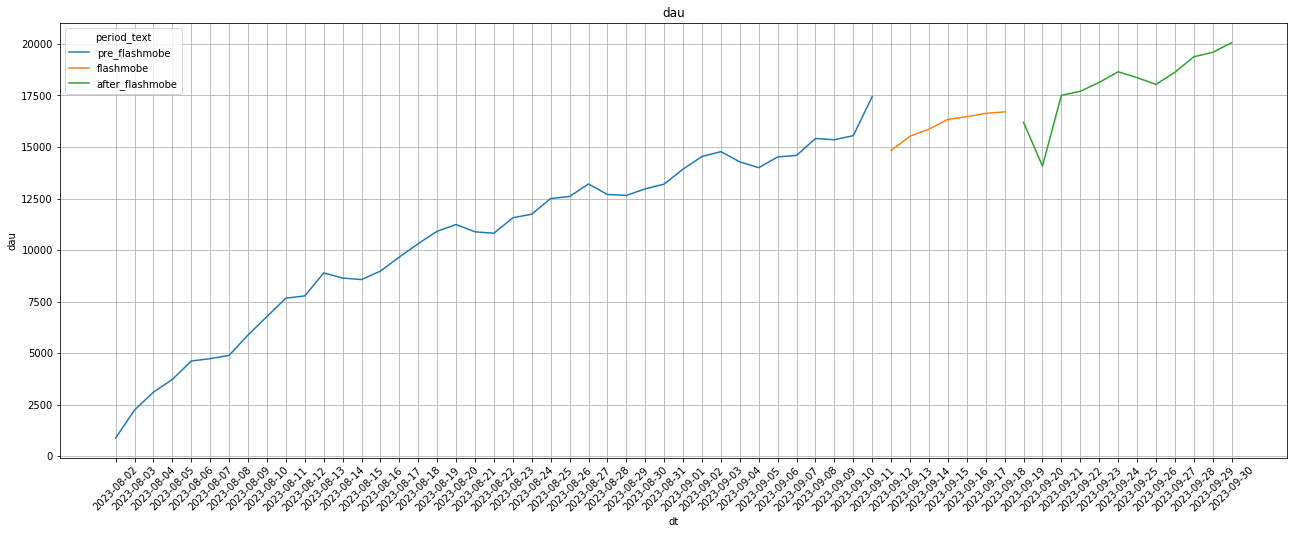

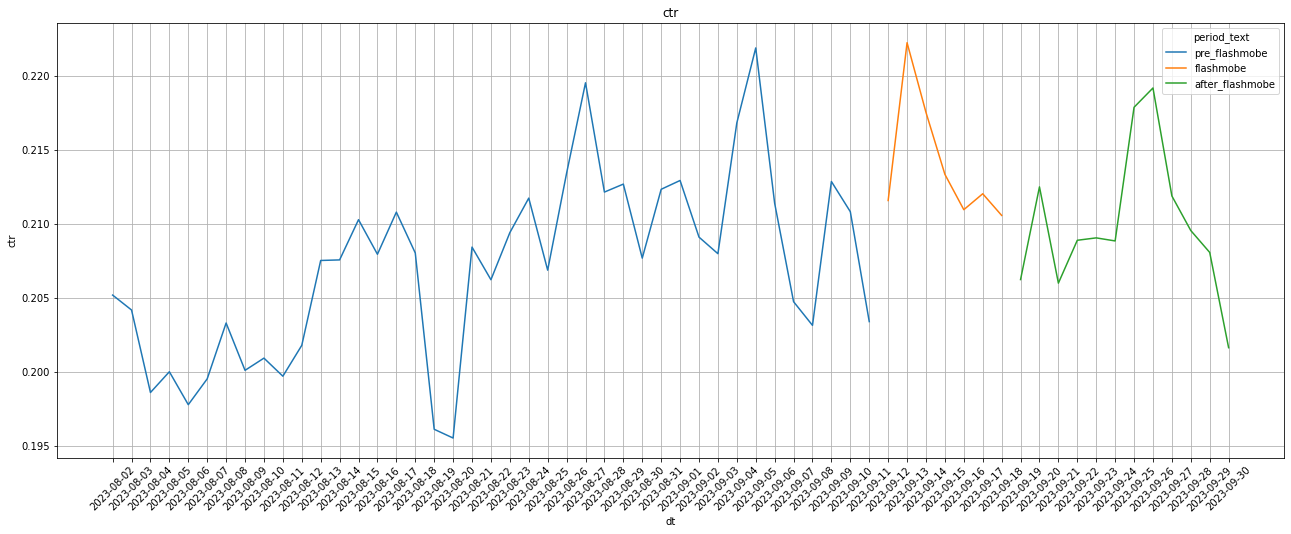

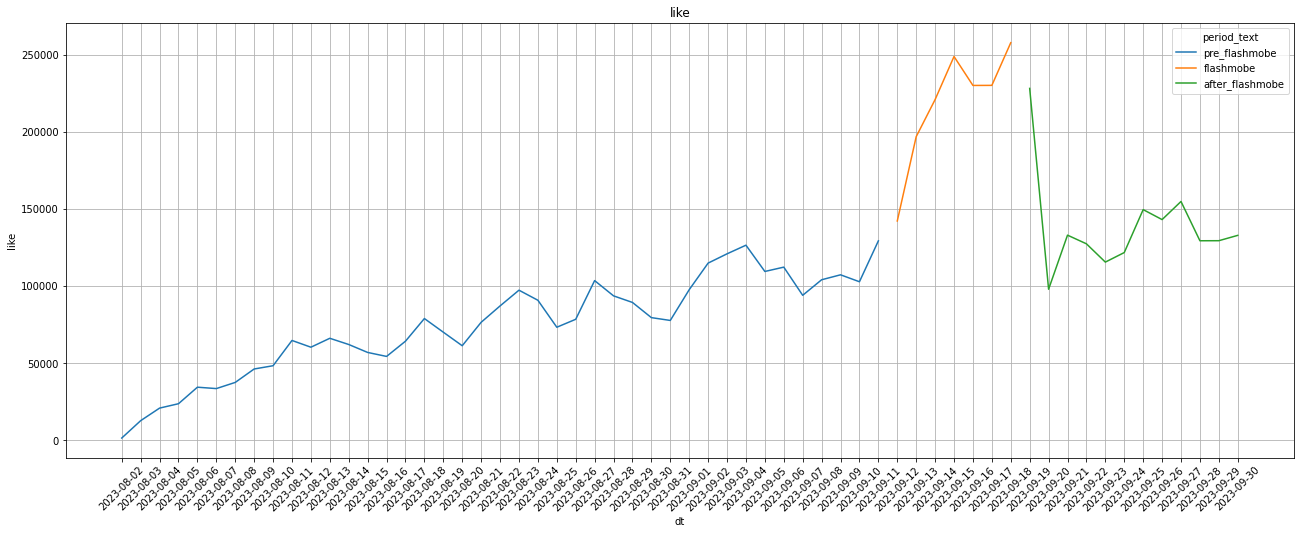

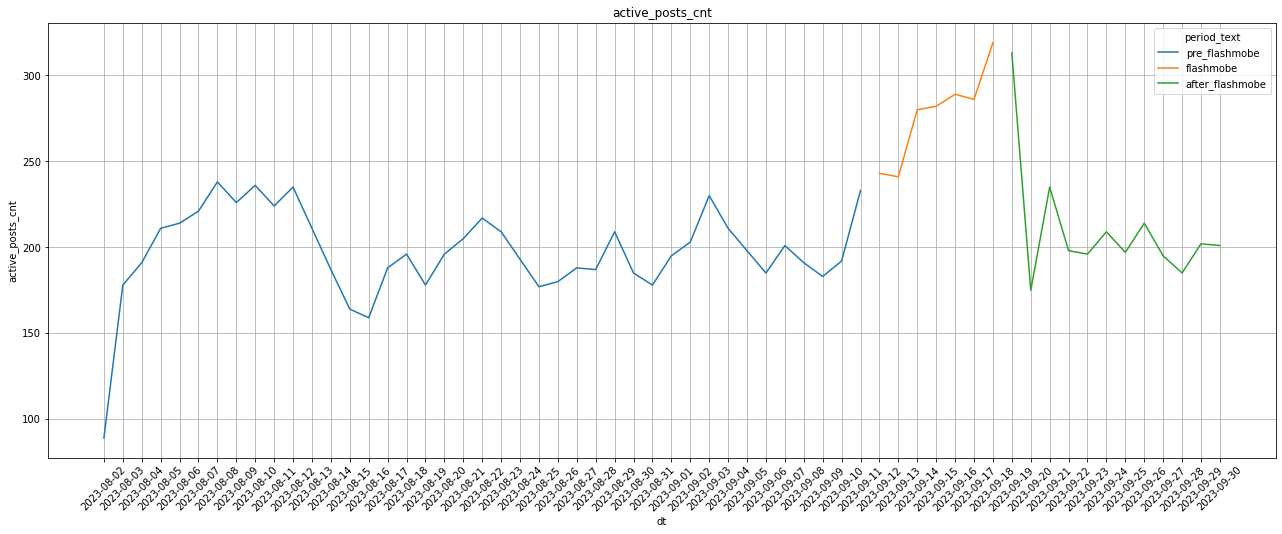

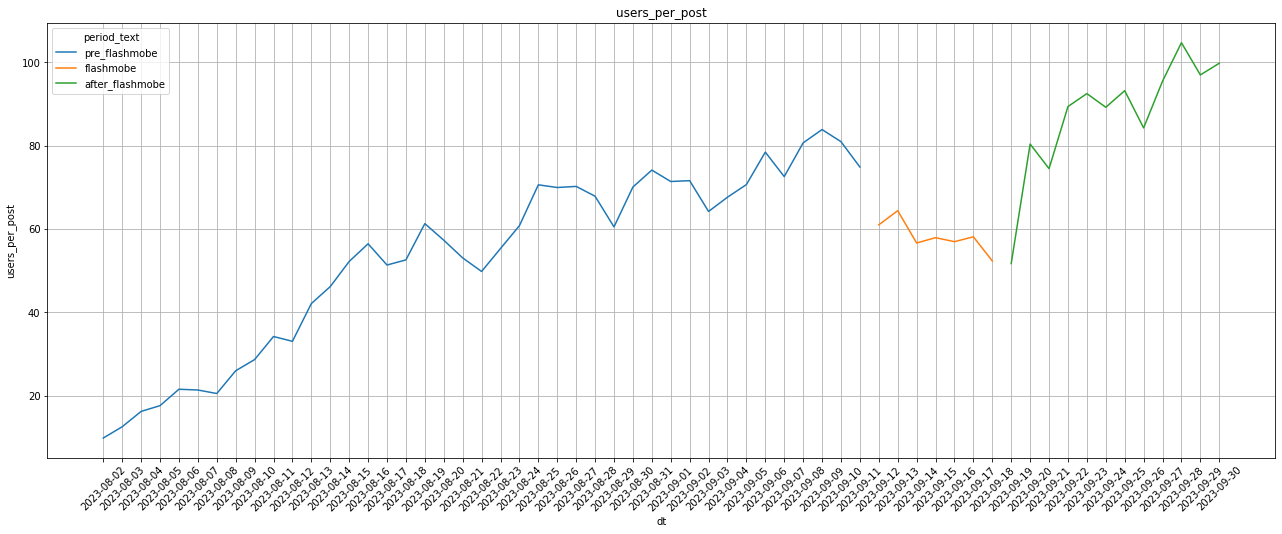

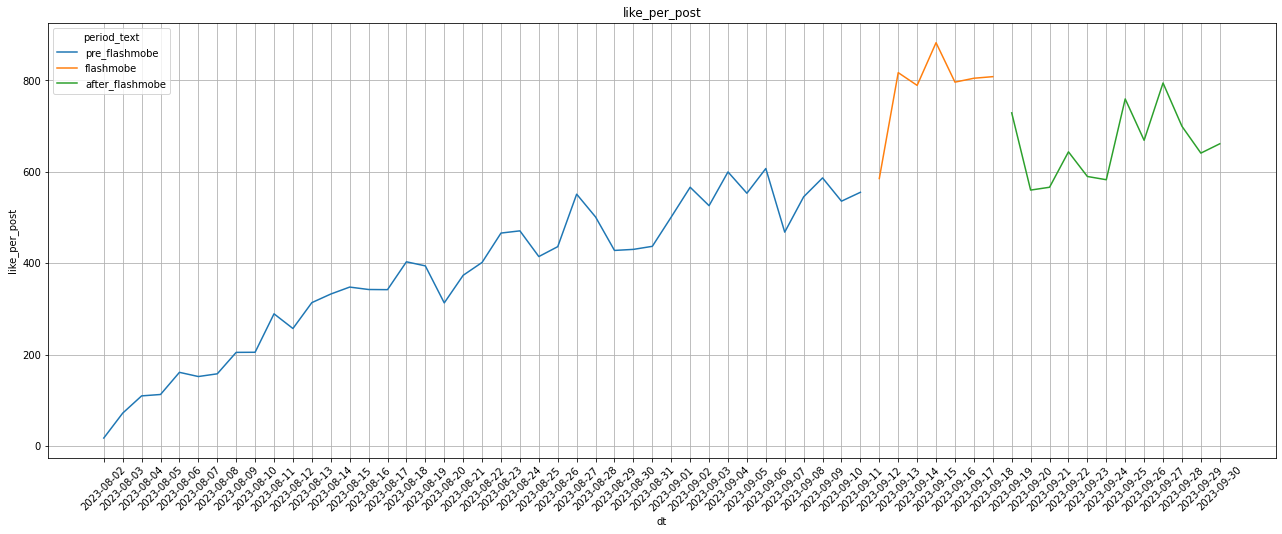

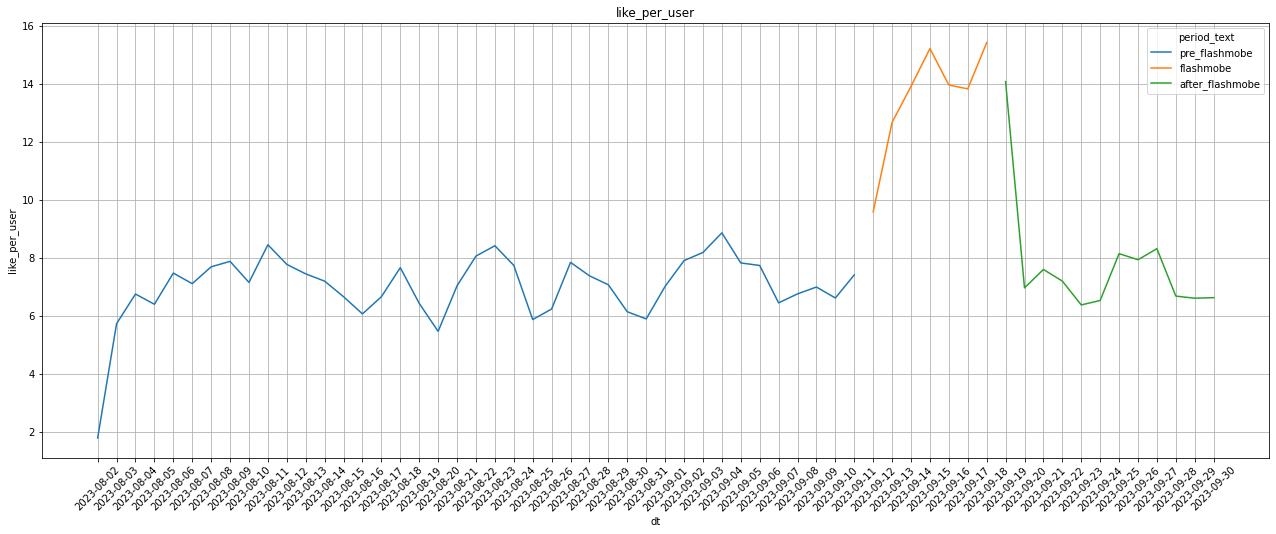

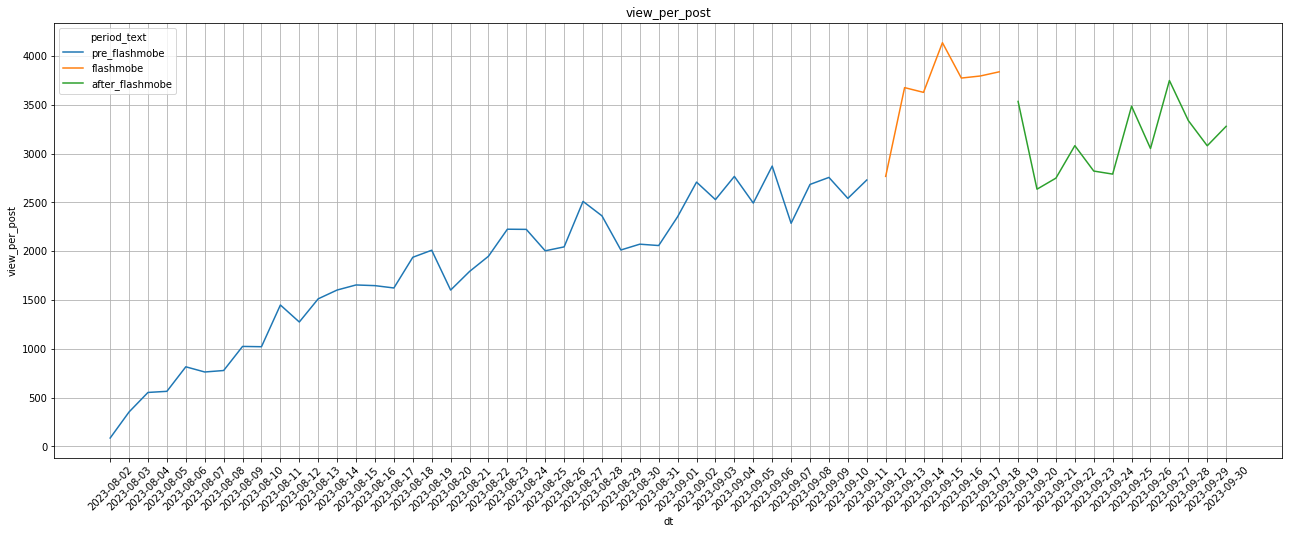

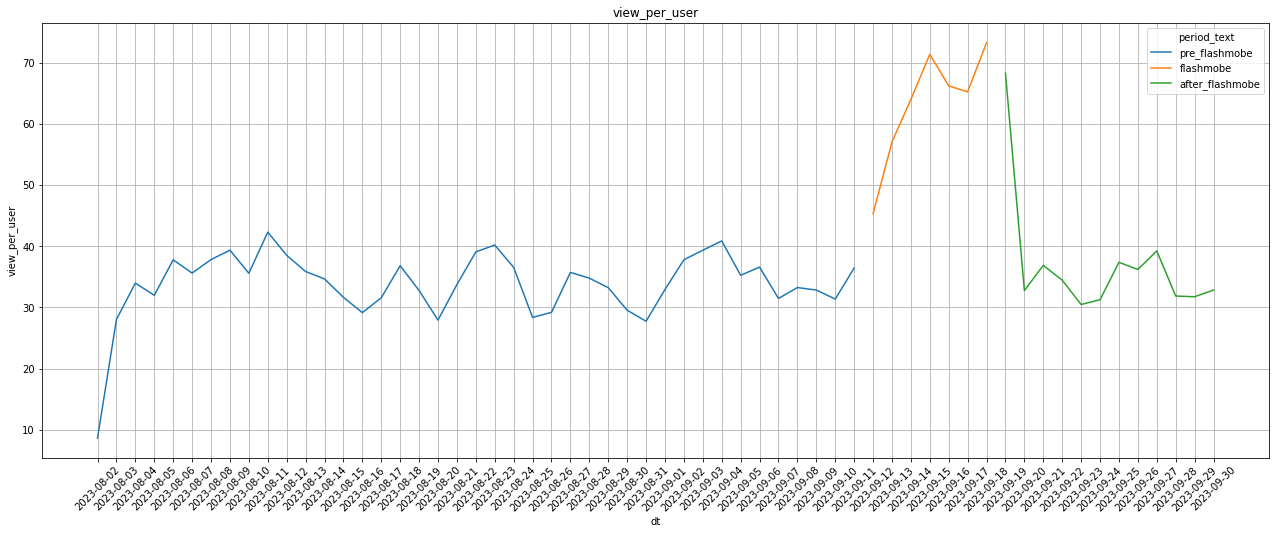

In [14]:
for i in day_metrics.df.columns:
    if i =='dt' or i == 'period_text':
        pass
    else:
        plt.figure(figsize=(22,8))
        plt.grid()
        plt.title(i)
        sns.lineplot(data=day_metrics.df, x='dt', y=i, hue='period_text')
        plt.xticks (ticks=sorted(day_metrics.df['dt'].unique()), rotation=45)
        plt.show()

На основании графиков складывается ощущение, что:
1. DAU сохранило свой тренд
2. CTR так же сохранил свой тренд, ранее (по времени) видны такие же пики
3. Все остальные показатели (Количество лайков, Количество активных уникальных постов, Количество лайков на 1 пост, Количество лайков на 1 пользователя, Количество просмотров на 1 пост, Количество просмотров на 1 пользователя) выросли

## Выведем предсказания по дневным метрикам 

Из дневных метрик возьмем DAU, лайки, CTR, лайки на 1 пост, лайки на 1 пользователя, и количесттво активных постов

In [15]:
min_date = day_metrics.df['dt'].min()

Ввиду наличия рекламной кампании 11 сентября, которая привела к сильному аномальному росту DAU, заменим значения всех метрик на среднее значение дат 2023-09-10 и 2023-09-12

In [16]:
day_metrics.df.query('dt >= "2023-09-10" and dt <= "2023-09-12"').iloc[:,1:-1]

,dau,ctr,like,active_posts_cnt,users_per_post,like_per_post,like_per_user,view_per_post,view_per_user
39,15549,0.210810,102839,192,80.984375,535.619792,6.613866,2540.765625,31.373529
40,17452,0.203392,129325,233,74.901288,555.042918,7.410325,2728.927039,36.433647
41,14829,0.211566,142206,243,61.024691,585.209877,9.589723,2766.082305,45.327264


In [17]:
columns_name = day_metrics.df.iloc[:,1:-1].columns
day_metrics.df.loc[day_metrics.df['dt'] == "2023-09-11", columns_name] = \
    day_metrics.df.query('dt == "2023-09-10" | dt == "2023-09-12"').iloc[:,1:-1].mean().values

In [18]:
day_metrics.df.query('dt >= "2023-09-10" and dt <= "2023-09-12"').iloc[:,1:-1]

,dau,ctr,like,active_posts_cnt,users_per_post,like_per_post,like_per_user,view_per_post,view_per_user
39,15549,0.210810,102839.0,192.0,80.984375,535.619792,6.613866,2540.765625,31.373529
40,15189,0.211188,122522.5,217.5,71.004533,560.414834,8.101794,2653.423965,38.350396
41,14829,0.211566,142206.0,243.0,61.024691,585.209877,9.589723,2766.082305,45.327264


------------------------------------------------------------------------------------------------------------------------
Исследуем столбец dau
------------------------------------------------------------------------------------------------------------------------
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


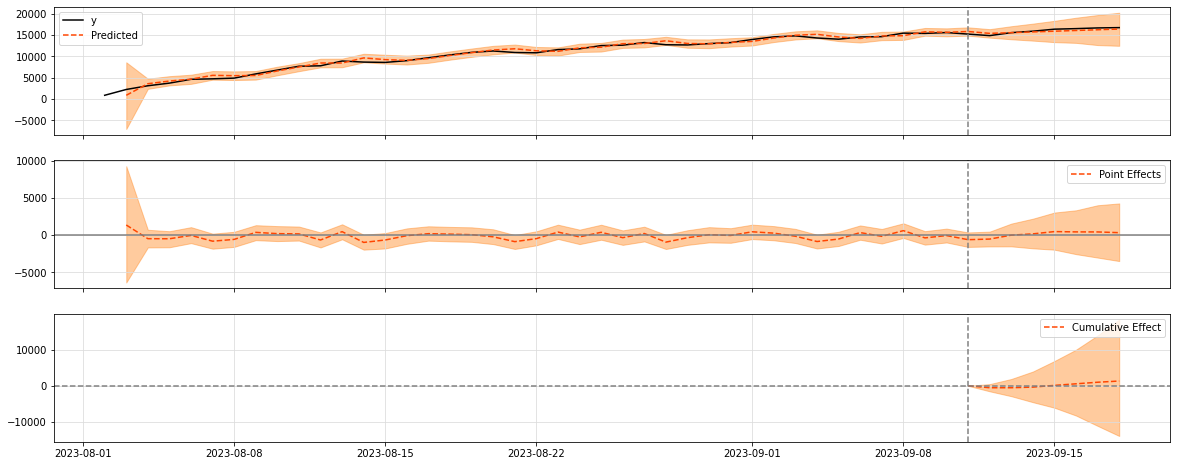

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.7139         112369.0
Prediction (s.d.)         15864.6963 (1116.2996)111052.875 (7814.0962)
95% CI                    [13612.9999, 17988.8146][95290.9961, 125921.6969]

Absolute effect (s.d.)    188.0176 (1116.2996)1316.125 (7814.0962)
95% CI                    [-1936.1008, 2439.714][-13552.6969, 17078.0039]

Relative effect (s.d.)    1.1851% (7.04%)    1.1851% (7.04%)
95% CI                    [-12.2038%, 15.3783%][-12.2038%, 15.3783%]

Posterior tail-area probability p: 0.4785
Posterior prob. of a causal effect: 52.1479%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец like
------------------------------------------------------------------------------------------------------------------------


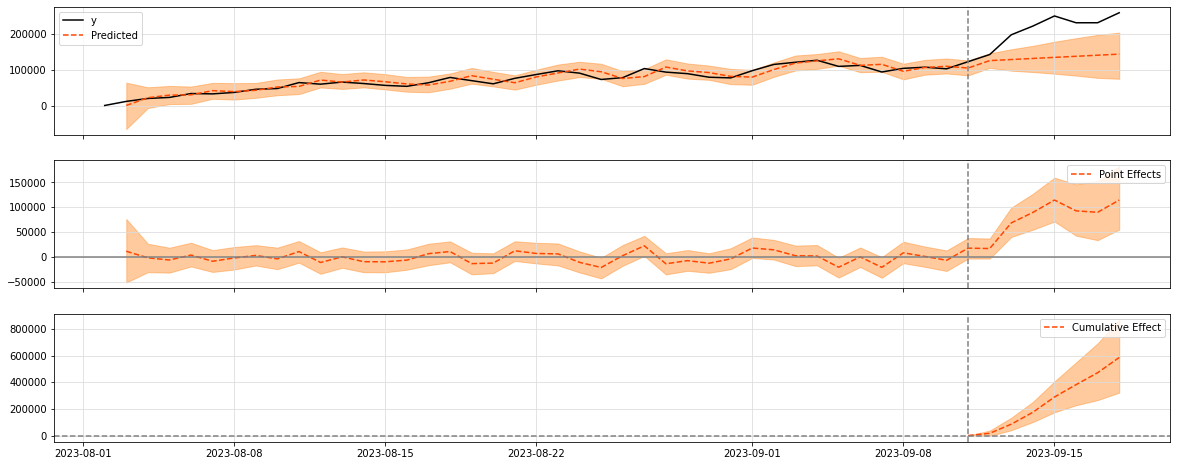

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.1406        1526631.0
Prediction (s.d.)         134439.6562 (18884.9734)941077.625 (132194.8269)
95% CI                    [97849.1918, 171876.9426][684944.3203, 1203138.6281]

Absolute effect (s.d.)    83650.4844 (18884.9734)585553.375 (132194.8269)
95% CI                    [46213.198, 120240.9488][323492.3719, 841686.6797]

Relative effect (s.d.)    62.2216% (14.05%)  62.2216% (14.05%)
95% CI                    [34.3747%, 89.4386%][34.3747%, 89.4386%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец like_per_user
-----------------------------------------------------------------------------------------------------------------

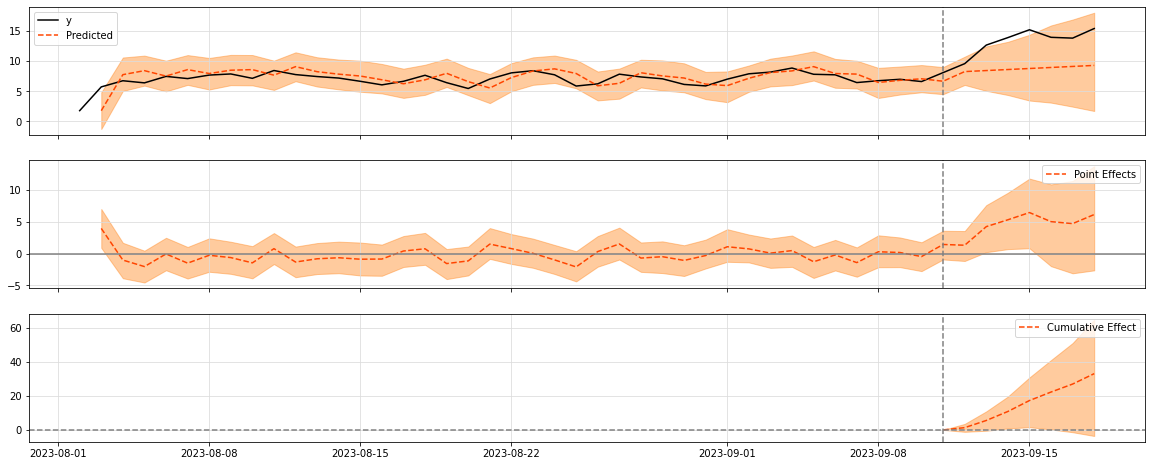

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    13.521             94.6473
Prediction (s.d.)         8.785 (2.6048)     61.4947 (18.2338)
95% CI                    [4.1852, 14.396]   [29.2966, 100.7717]

Absolute effect (s.d.)    4.7361 (2.6048)    33.1527 (18.2338)
95% CI                    [-0.8749, 9.3358]  [-6.1244, 65.3508]

Relative effect (s.d.)    53.9114% (29.65%)  53.9114% (29.65%)
95% CI                    [-9.9592%, 106.2706%][-9.9592%, 106.2706%]

Posterior tail-area probability p: 0.034
Posterior prob. of a causal effect: 96.6034%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец ctr
------------------------------------------------------------------------------------------------------------------------


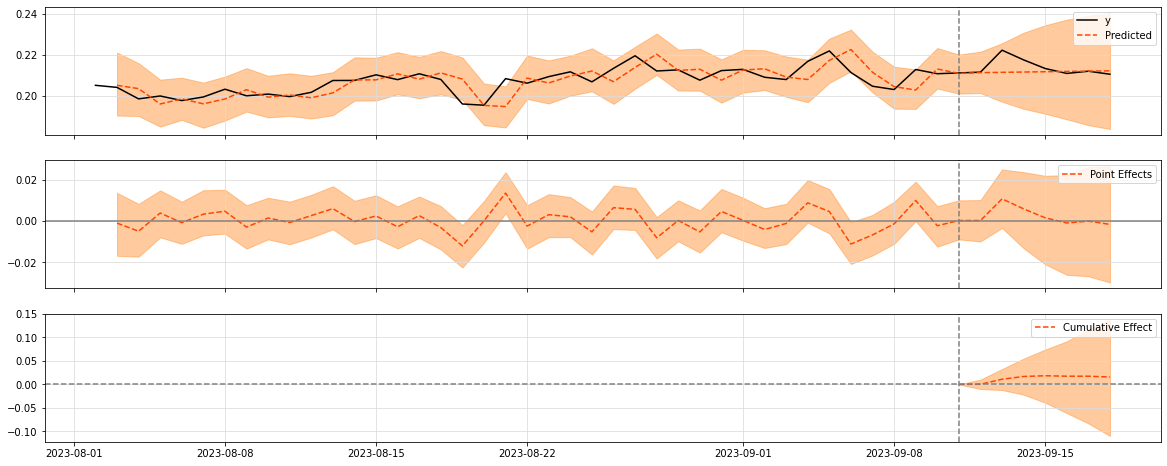

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.214              1.4982
Prediction (s.d.)         0.2118 (0.0097)    1.4824 (0.0682)
95% CI                    [0.1926, 0.2308]   [1.3484, 1.6158]

Absolute effect (s.d.)    0.0023 (0.0097)    0.0158 (0.0682)
95% CI                    [-0.0168, 0.0214]  [-0.1176, 0.1498]

Relative effect (s.d.)    1.0634% (4.6%)     1.0634% (4.6%)
95% CI                    [-7.9362%, 10.1047%][-7.9362%, 10.1047%]

Posterior tail-area probability p: 0.4076
Posterior prob. of a causal effect: 59.2408%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец like_per_post
------------------------------------------------------------------------------------------------------------------------


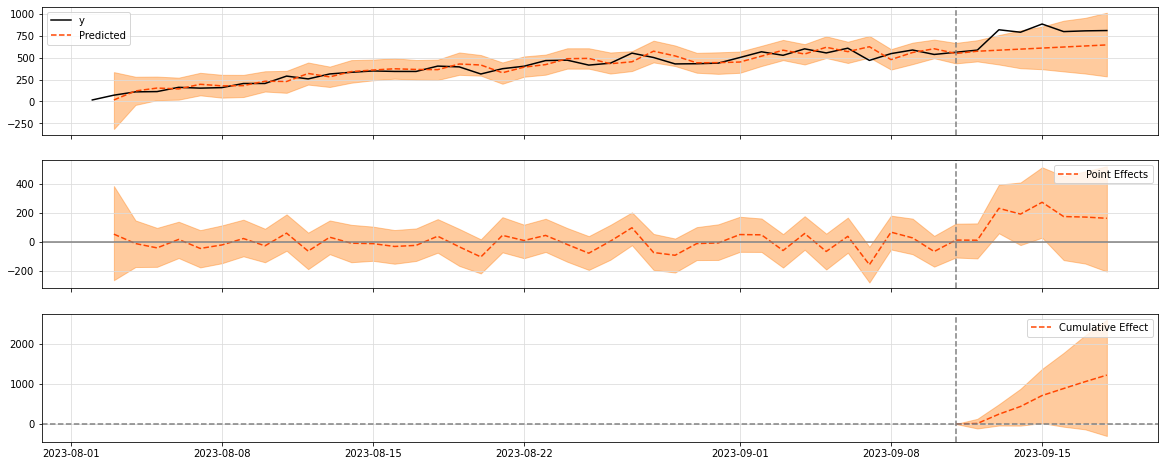

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    783.0974           5481.6816
Prediction (s.d.)         608.3972 (114.0462)4258.7803 (798.3236)
95% CI                    [395.803, 842.8561][2770.6206, 5899.9925]

Absolute effect (s.d.)    174.7002 (114.0462)1222.9014 (798.3236)
95% CI                    [-59.7587, 387.2944][-418.3108, 2711.061]

Relative effect (s.d.)    28.7148% (18.75%)  28.7148% (18.75%)
95% CI                    [-9.8223%, 63.6582%][-9.8223%, 63.6582%]

Posterior tail-area probability p: 0.0589
Posterior prob. of a causal effect: 94.1059%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец active_posts_cnt
------------------------------------------------------------------------------------------------------------------------


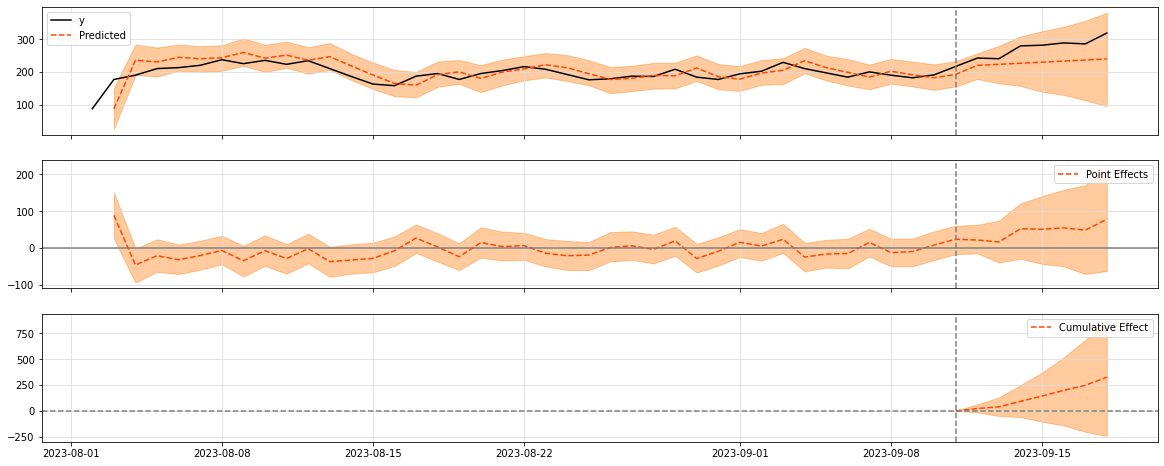

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    277.1429           1940.0
Prediction (s.d.)         230.568 (42.5292)  1613.9761 (297.7047)
95% CI                    [150.4908, 317.2024][1053.4357, 2220.4172]

Absolute effect (s.d.)    46.5748 (42.5292)  326.0239 (297.7047)
95% CI                    [-40.0596, 126.652][-280.4172, 886.5643]

Relative effect (s.d.)    20.2% (18.45%)     20.2% (18.45%)
95% CI                    [-17.3743%, 54.9304%][-17.3743%, 54.9304%]

Posterior tail-area probability p: 0.1389
Posterior prob. of a causal effect: 86.1139%

For more details run the command: print(impact.summary('report'))


In [19]:
get_causalimpactdata(
    day_metrics.df[['dt', 'dau', 'like', 'like_per_user', 'ctr', 'like_per_post',  'active_posts_cnt']], 
    'dt', 
    [min_date, '20230911'], 
    ['20230912', '20230918'], 
    model_args={'nseasons': 1, 'season_duration':1}
)

## Выведем информацию по количеству постов, согласно первой дате появления

------------------------------------------------------------------------------------------------------------------------
Исследуем столбец uniq_posts_cnt
------------------------------------------------------------------------------------------------------------------------


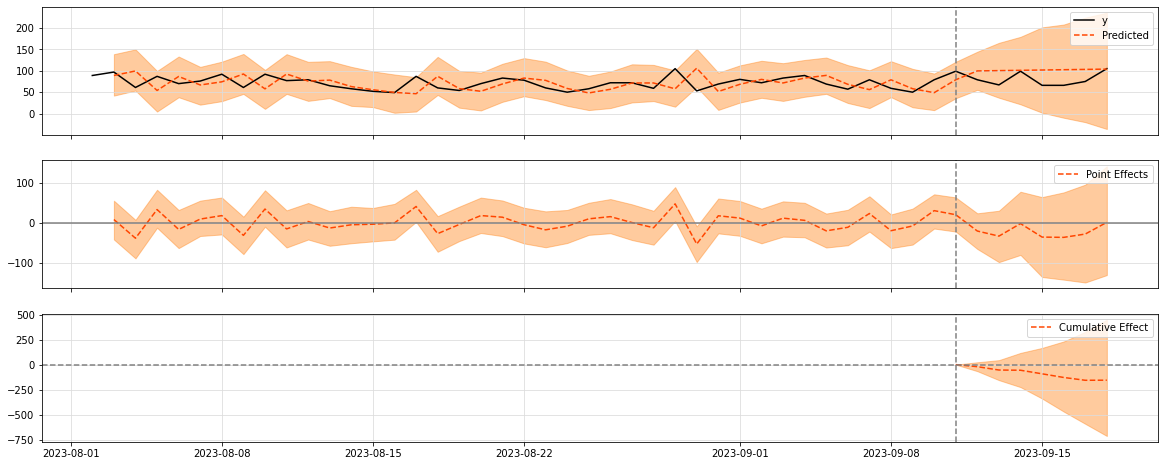

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.5714            557.0
Prediction (s.d.)         101.8221 (39.7536) 712.7549 (278.2749)
95% CI                    [27.5528, 183.384] [192.8698, 1283.6877]

Absolute effect (s.d.)    -22.2507 (39.7536) -155.7549 (278.2749)
95% CI                    [-103.8125, 52.0186][-726.6877, 364.1302]

Relative effect (s.d.)    -21.8525% (39.04%) -21.8525% (39.04%)
95% CI                    [-101.9548%, 51.0877%][-101.9548%, 51.0877%]

Posterior tail-area probability p: 0.3017
Posterior prob. of a causal effect: 69.8302%

For more details run the command: print(impact.summary('report'))


In [20]:
get_causalimpactdata(uniq_posts_per_day.df, 'dt', [min_date, '20230911'], ['20230912', '20230918'], model_args={'nseasons': 1, 'season_duration':1})

## Проверим на наличие долгосрочных эффектов от флешмоба

Посмотрим на период после флешмоба, так же с помощью библиотеки causalimpact. На этот раз исключим даты флешмоба из модели, период поделим на до флешмоба и после, смотреть будем до 30 сентября 2023 года включительно. Так как 19 сентября (на следующий день после флешмоба) наблюдается большие значения по некоторым метрикам (по активным постам, лайкам и т.п.), не будем учитывать это число в модели, начнем с 20 сентября (что бы невилировать эффект сразу после флешмоба).

------------------------------------------------------------------------------------------------------------------------
Исследуем столбец dau
------------------------------------------------------------------------------------------------------------------------


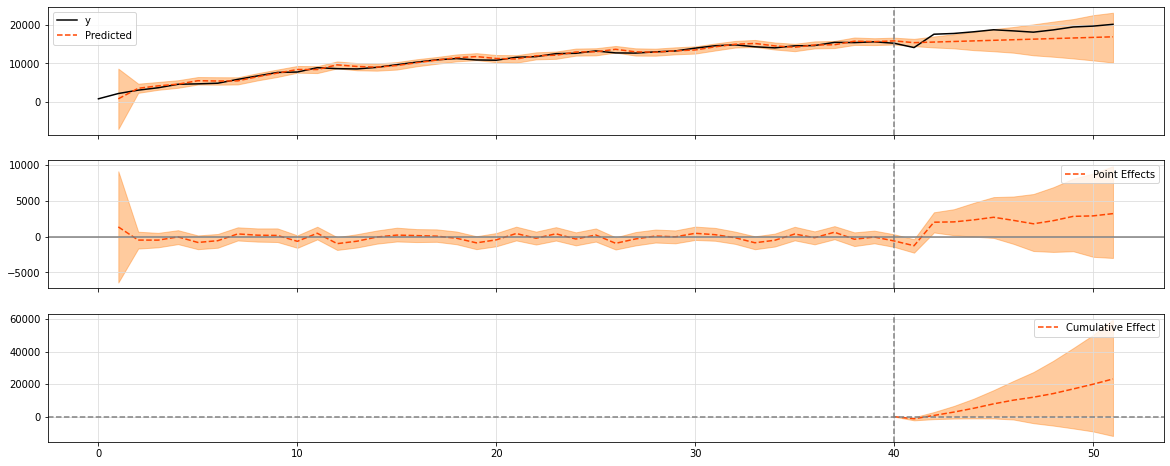

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    18193.4551         200128.0
Prediction (s.d.)         16089.4229 (1747.8143)176983.6562 (19225.957)
95% CI                    [12242.4215, 19093.729][134666.6398, 210031.0223]

Absolute effect (s.d.)    2104.0322 (1747.8143)23144.3438 (19225.957)
95% CI                    [-900.2739, 5951.0335][-9903.0223, 65461.3602]

Relative effect (s.d.)    13.0771% (10.86%)  13.0771% (10.86%)
95% CI                    [-5.5954%, 36.9872%][-5.5954%, 36.9872%]

Posterior tail-area probability p: 0.0889
Posterior prob. of a causal effect: 91.1089%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец like
------------------------------------------------------------------------------------------------------------------------


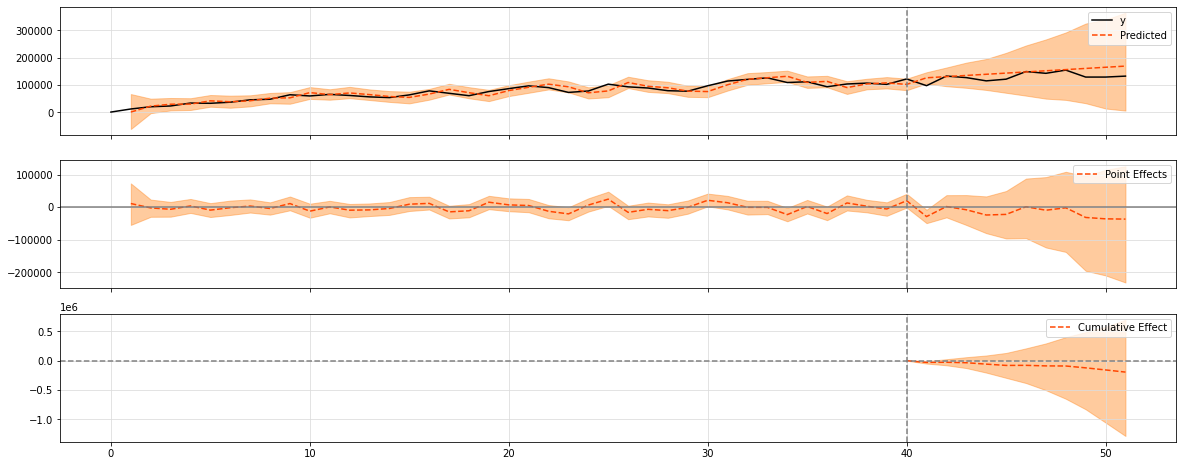

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    130457.4531        1435032.0
Prediction (s.d.)         148164.75 (41920.5541)1629812.25 (461126.0945)
95% CI                    [75117.5887, 239443.1754][826293.4906, 2633874.9437]

Absolute effect (s.d.)    -17707.2969 (41920.5541)-194780.25 (461126.0945)
95% CI                    [-108985.7223, 55339.8645][-1198842.9437, 608738.5094]

Relative effect (s.d.)    -11.9511% (28.29%) -11.9511% (28.29%)
95% CI                    [-73.5571%, 37.3502%][-73.5571%, 37.3502%]

Posterior tail-area probability p: 0.3277
Posterior prob. of a causal effect: 67.2328%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец like_per_user
------------------------------------------------------------------------------------------------------

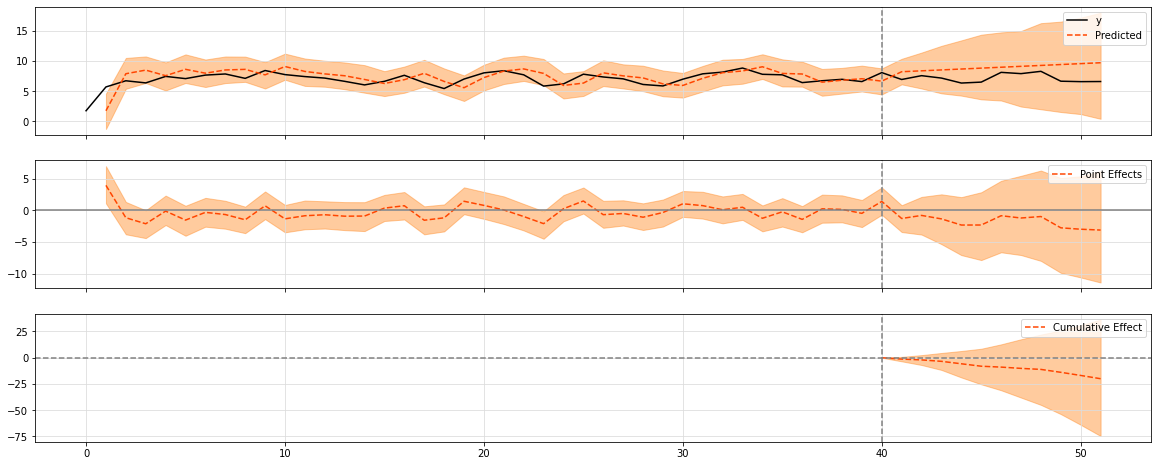

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7.1783             78.9613
Prediction (s.d.)         8.9956 (2.5048)    98.9517 (27.5527)
95% CI                    [4.1347, 13.9533]  [45.4815, 153.4861]

Absolute effect (s.d.)    -1.8173 (2.5048)   -19.9904 (27.5527)
95% CI                    [-6.775, 3.0436]   [-74.5248, 33.4798]

Relative effect (s.d.)    -20.2022% (27.84%) -20.2022% (27.84%)
95% CI                    [-75.3143%, 33.8345%][-75.3143%, 33.8345%]

Posterior tail-area probability p: 0.2438
Posterior prob. of a causal effect: 75.6244%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец ctr
------------------------------------------------------------------------------------------------------------------------


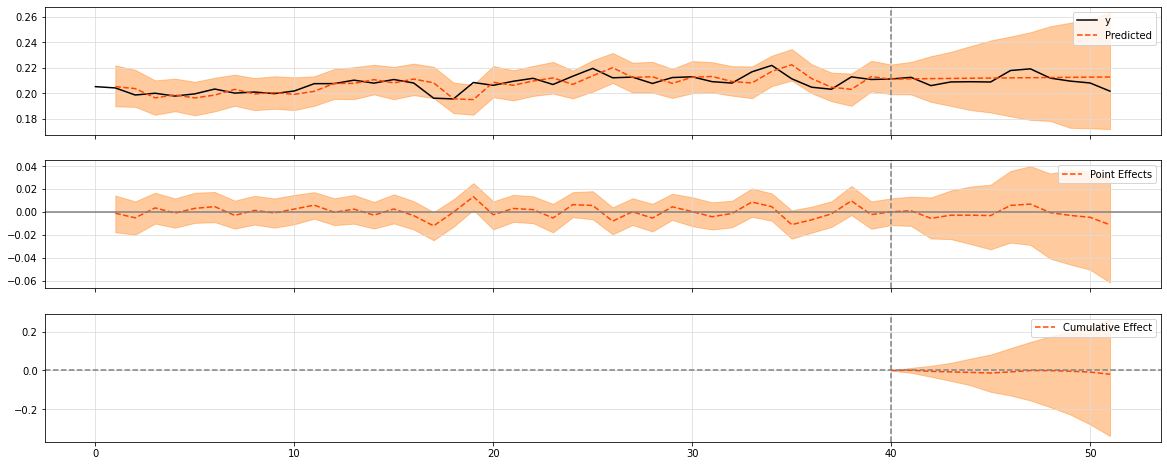

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.2103             2.3134
Prediction (s.d.)         0.2121 (0.0139)    2.3327 (0.1526)
95% CI                    [0.1828, 0.2372]   [2.0112, 2.6095]

Absolute effect (s.d.)    -0.0018 (0.0139)   -0.0193 (0.1526)
95% CI                    [-0.0269, 0.0275]  [-0.2961, 0.3022]

Relative effect (s.d.)    -0.8279% (6.54%)   -0.8279% (6.54%)
95% CI                    [-12.6939%, 12.9544%][-12.6939%, 12.9544%]

Posterior tail-area probability p: 0.4825
Posterior prob. of a causal effect: 51.7483%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец like_per_post
------------------------------------------------------------------------------------------------------------------------


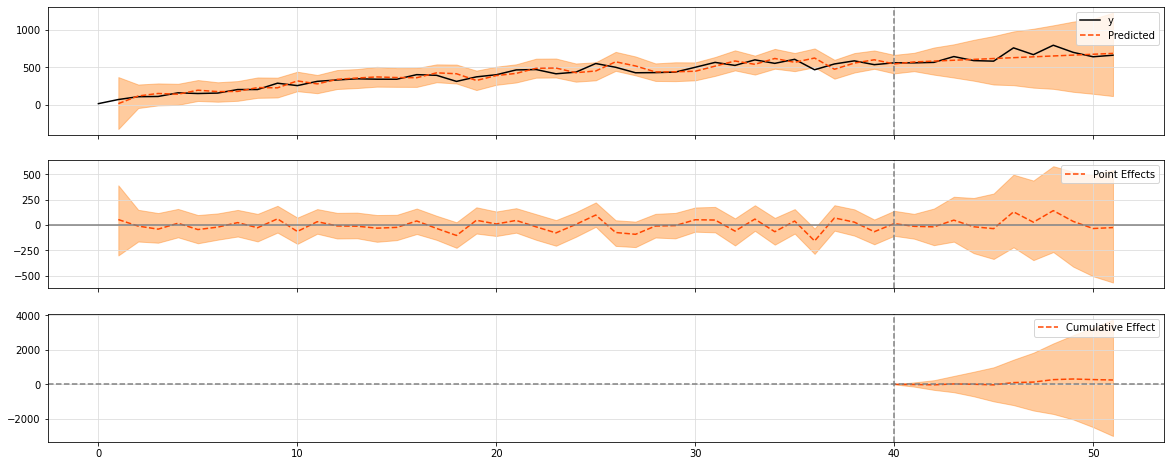

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    651.3881           7165.2695
Prediction (s.d.)         628.7105 (174.5293)6915.8159 (1919.8226)
95% CI                    [272.9915, 957.1341][3002.9065, 10528.4745]

Absolute effect (s.d.)    22.6776 (174.5293) 249.4536 (1919.8226)
95% CI                    [-305.746, 378.3966][-3363.205, 4162.363]

Relative effect (s.d.)    3.607% (27.76%)    3.607% (27.76%)
95% CI                    [-48.6306%, 60.1861%][-48.6306%, 60.1861%]

Posterior tail-area probability p: 0.4376
Posterior prob. of a causal effect: 56.2438%

For more details run the command: print(impact.summary('report'))
------------------------------------------------------------------------------------------------------------------------
Исследуем столбец active_posts_cnt
------------------------------------------------------------------------------------------------------------------------


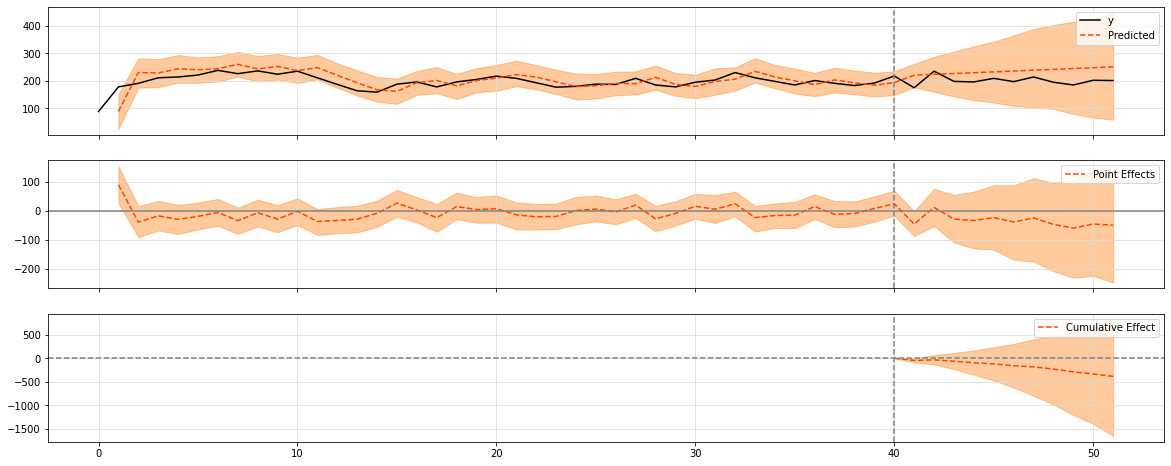

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    200.6364           2207.0
Prediction (s.d.)         235.4729 (58.5082) 2590.2021 (643.5902)
95% CI                    [117.2702, 346.6182][1289.9727, 3812.8003]

Absolute effect (s.d.)    -34.8365 (58.5082) -383.2021 (643.5902)
95% CI                    [-145.9818, 83.3661][-1605.8003, 917.0273]

Relative effect (s.d.)    -14.7943% (24.85%) -14.7943% (24.85%)
95% CI                    [-61.9952%, 35.4037%][-61.9952%, 35.4037%]

Posterior tail-area probability p: 0.2677
Posterior prob. of a causal effect: 73.2268%

For more details run the command: print(impact.summary('report'))


In [21]:
get_causalimpactdata(
    day_metrics.df[['dt', 'dau', 'like', 'like_per_user', 'ctr', 'like_per_post', 'active_posts_cnt']], '',
    [0, int(day_metrics.df.query('dt == "2023-09-12"').index.min() - 1)],
    [int(day_metrics.df.query('dt == "2023-09-20"').index.min()), int(day_metrics.df.index.max())], 
    model_args={'nseasons': 1, 'season_duration':1}
)

------------------------------------------------------------------------------------------------------------------------
Исследуем столбец uniq_posts_cnt
------------------------------------------------------------------------------------------------------------------------


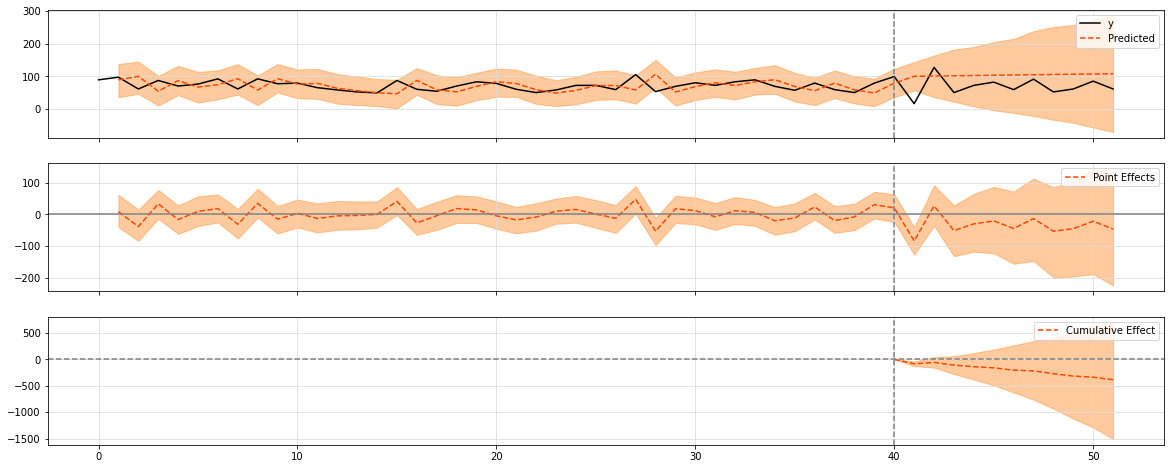

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    68.7273            756.0
Prediction (s.d.)         103.7225 (52.5425) 1140.9478 (577.9678)
95% CI                    [1.9667, 207.9297] [21.634, 2287.2267]

Absolute effect (s.d.)    -34.9953 (52.5425) -384.9478 (577.9678)
95% CI                    [-139.2024, 66.7605][-1531.2267, 734.366]

Relative effect (s.d.)    -33.7393% (50.66%) -33.7393% (50.66%)
95% CI                    [-134.2066%, 64.3646%][-134.2066%, 64.3646%]

Posterior tail-area probability p: 0.2378
Posterior prob. of a causal effect: 76.2238%

For more details run the command: print(impact.summary('report'))


In [22]:
get_causalimpactdata(
    uniq_posts_per_day.df, '',
    [0, int(uniq_posts_per_day.df.query('dt == "2023-09-12"').index.min() - 1)],
    [int(uniq_posts_per_day.df.query('dt == "2023-09-20"').index.min()), int(uniq_posts_per_day.df.index.max())], 
    model_args={'nseasons': 1, 'season_duration':1}
)

## ВЫВОД

Краткий вывод. В период флешмоба был прирост метрик like, like_per_user, CTR, Количество активных постов в сутки. В период после флешмоба, практически все метрики вернулись в пределы естественных изменений, которые имели место и до флешмоба.  

1.	**Метрика DAU:**
    1.	визуально сохраняется тренд на планомерный рост аудитории, похожие результаты демонстрирует модель, прирост составил 1,12% а p-value равняется 0.45, что говорит о том, что вероятность получить такой эффект случайно достаточно высока (уровень альфа у нас 0.05). То есть, планомерный рост хорошо предсказывается нашей моделью.
    2.	В 10-ти дневный срок после флешмоба рост DAU продолжается, модель зафиксировала изменения на 13% с p-value = 0.08, что выше уровня принятой альфа. С учетом того, что период флешмоба мы выкинули из рассмотрения, мы можем утверждать, что все это продолжение естественного плавного роста, возможно с минимальным наложением отпечатка от флешмоба.
    
2.	**Метрика like:**
    1.	На период флешмоба рост лайков составляет 62%, а p-value равняется 0, что говорит о том, что такой эффект можно считать статистически значимым (флешмоб напрямую повлиял на это), особенно с учетом того, что рост DAU показывал более скромные масштабы 
    2.	В 10-ти дневный срок после флешмоба количество лайков уменьшилось относительно модели на 11%, а p-value = 0.3277, что в целом говорит о том, что модель допускает такое развитие событий, возможно из за высокой активности во время флешмоба наблюдается небольшое торможение в росте лайков, и со временем все выправится.
    
3.	**Метрика like_per_user:**
    1.	Во время флешмоба прирост составил 92% от предсказываемой модели, и p-value = 0.0, в связи с чем можно сказать, что результат статистически значим. Другими словами, пользователи стали чаще лайкать посты.
    2.	В 10-ти дневный срок после флешмоба модель зафиксировала падение в 20%, при p-value = 0.2438, что говорит о том, что вероятность получить такой эффект случайно достаточно высока. Как следствие пользователи лайкают примерно так же часто, как и до флешмоба, причины падения те же, что и для метрики like, а также эта метрика намного более стационарна чем like
    
4.	**CTR:**
    1.	Во время флешмоба прирост составил 1.06% от предсказываемой модели, и p-value = 0.40, в связи с чем можно сказать, что флешмоб не повлиял на данную метрику. 
    2.	В 10-ти дневный срок после флешмоба зафиксировано падение в -0.8% относительно показателей до флешмоба, p-value = 0.48. Учитывая полученный график, и полученные доверительные интервалы, скорее всего это обычное колебание CTR. Но как минимум флешмоб не привел к значительному изменению тренда данного показателя. 
    
5.	**Количество активных постов в сутки:**
    1.	Во время флешмоба выросло число постов, с которыми взаимодействовали пользователи, рост от предсказанной модели составил 20.2%, p-value = 0.1389, что указывает на то, что модель неплохо предсказывает данную метрику, то есть флешмоб на нее особо не повлиял.
    2.	В 10-ти дневный срок после флешмоба зафиксировано падение в 15%, при p-value = 0.2677. Из полученных данных и графика можно сделать вывод, что флешмоб не повлиял значительно на изменение данной метрики.
    
6.	**Количество постов в сутки, которые первый раз появились на платформе:**
    1.	Во время флешмоба зафиксирован упадок в 22% относительно предсказанного значения, при p-value = 0.30, и с учетом самого графика можно сказать, что флешмоб никак не повлиял на данную метрику, и фактическая картина хорошо соответствует предсказанию. 
    2. В 10-ти дневный срок после флешмоба модель зафиксировала падение данной метрики на 33%, при p-value = 0.23. При этом полученные значения находятся в середине доверительного интервала, с учетом графика можно говорить о том, что метрика в двух сравниваемых периодах одинакова.
